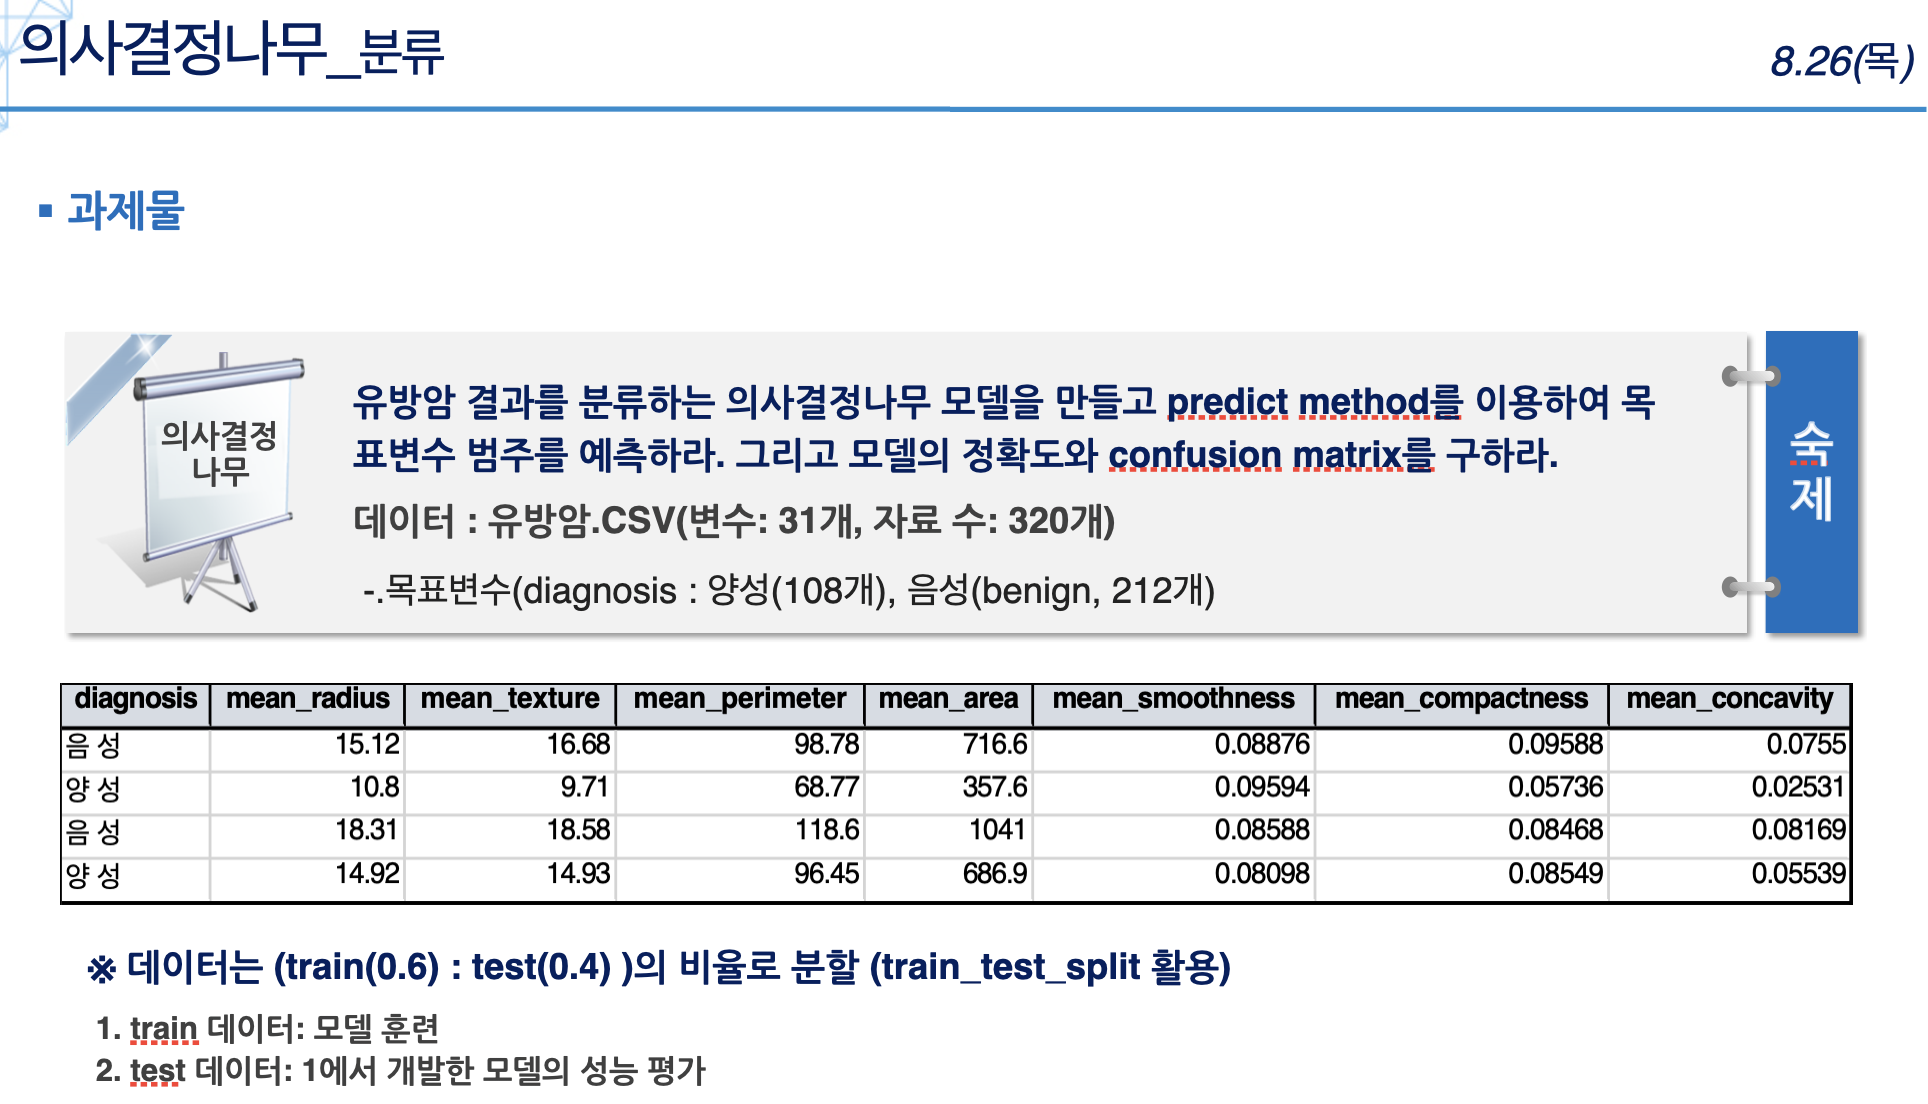

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats
from scipy import stats
from scipy.stats import ttest_rel
from scipy.stats import ttest_ind
from scipy.stats import shapiro
from scipy.stats import chi2_contingency
from scipy.stats import mannwhitneyu

from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.stattools import omni_normtest

from statsmodels.formula.api import ols
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.api import qqplot, add_constant

from sklearn.preprocessing import scale, minmax_scale, robust_scale
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale
from statsmodels.tools.eval_measures import rmse

from sklearn.model_selection import train_test_split

#분류
from statsmodels.api import Logit
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report

%matplotlib inline
sns.set(font="AppleGothic")
plt.rcParams['axes.unicode_minus']=False

# 1. 데이터 정제

### 1-0. 데이터 이해
변수는 31개, 데이터 개수는 320개로 데이터에 비해 변수 개수가 많다.

데이터는 평균, 표준오차, 최대값으로 이루어져있다.

### 1-1.결측치: 없음
### 1-2.이상치: Boxplot 분포 확인
세포의 radius error(반경의 표준오차), texture error(질감의 표준오차), perimeter error(둘레의 표준오차), area error(면적의 표준오차), worst area(최대 면적)에 이상치일 가능성이 있는 데이터가 있다.
### 1-3.데이터 변환: 목표 변수인 유방암 진단결과를 0(음성),1(양성)로 변환


In [3]:
df = pd.read_csv('유방암.csv', engine='python', encoding='cp949')
df.head(n=3)

,diagnosis,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,mean_compactness,mean_concavity,mean_concave_points,mean_symmetry,...,worst_radius,worst_texture,worst_perimeter,worst_area,worst_smoothness,worst_compactness,worst_concavity,worst_concave_points,worst_symmetry,worst_fractal_dimension
0,음성,15.12,16.68,98.78,716.6,0.08876,0.09588,0.07550,0.04079,0.1594,...,17.77,20.24,117.70,989.5,0.1491,0.3331,0.3327,0.12520,0.3415,0.09740
1,양성,10.80,9.71,68.77,357.6,0.09594,0.05736,0.02531,0.01698,0.1381,...,11.60,12.02,73.66,414.0,0.1436,0.1257,0.1047,0.04603,0.2090,0.07699
2,음성,18.31,18.58,118.60,1041.0,0.08588,0.08468,0.08169,0.05814,0.1621,...,21.31,26.36,139.20,1410.0,0.1234,0.2445,0.3538,0.15710,0.3206,0.06938


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 320 entries, 0 to 319
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   diagnosis                320 non-null    object 
 1   mean_radius              320 non-null    float64
 2   mean_texture             320 non-null    float64
 3   mean_perimeter           320 non-null    float64
 4   mean_area                320 non-null    float64
 5   mean_smoothness          320 non-null    float64
 6   mean_compactness         320 non-null    float64
 7   mean_concavity           320 non-null    float64
 8   mean_concave_points      320 non-null    float64
 9   mean_symmetry            320 non-null    float64
 10  mean_fractal_dimension   320 non-null    float64
 11  radius_error             320 non-null    float64
 12  texture_error            320 non-null    float64
 13  perimeter_error          320 non-null    float64
 14  area_error               3

# 결측치
없다.

In [5]:
df.isna().sum()

diagnosis                  0
mean_radius                0
mean_texture               0
mean_perimeter             0
mean_area                  0
mean_smoothness            0
mean_compactness           0
mean_concavity             0
mean_concave_points        0
mean_symmetry              0
mean_fractal_dimension     0
radius_error               0
texture_error              0
perimeter_error            0
area_error                 0
smoothness_error           0
compactness_error          0
concavity_error            0
concave_points_error       0
symmetry_error             0
fractal_dimension_error    0
worst_radius               0
worst_texture              0
worst_perimeter            0
worst_area                 0
worst_smoothness           0
worst_compactness          0
worst_concavity            0
worst_concave_points       0
worst_symmetry             0
worst_fractal_dimension    0
dtype: int64

# 이상치: Boxplot 분포 확인

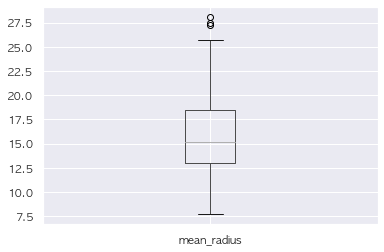

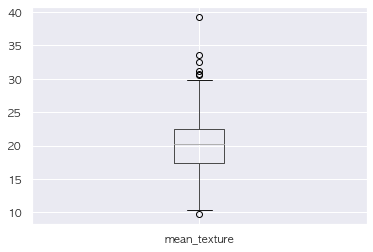

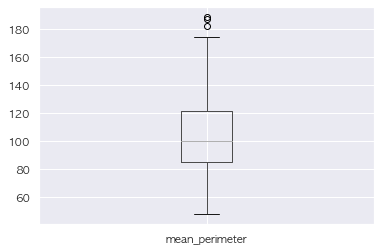

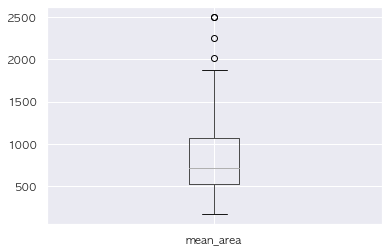

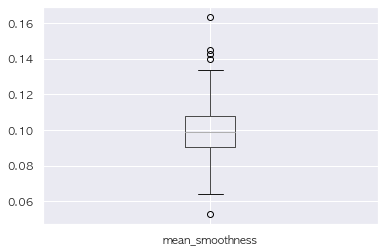

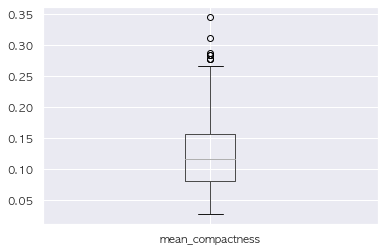

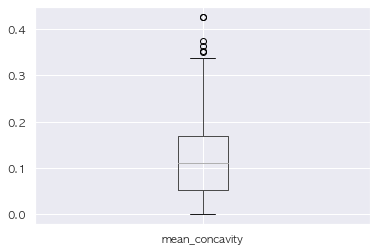

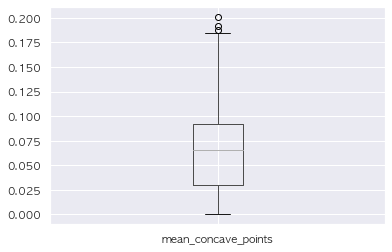

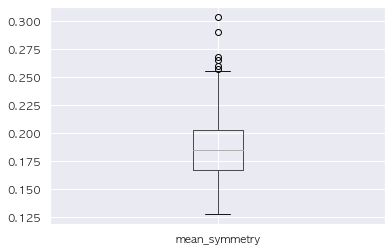

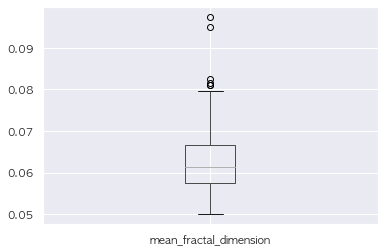

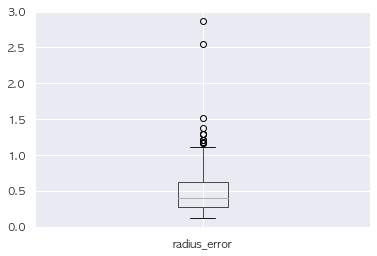

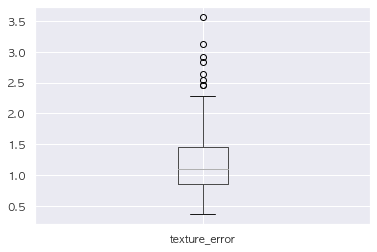

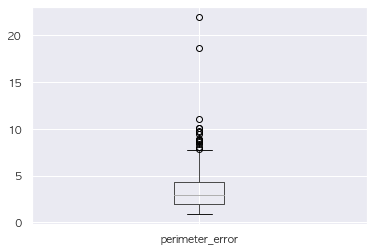

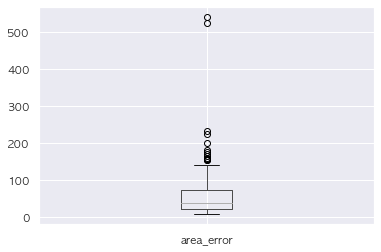

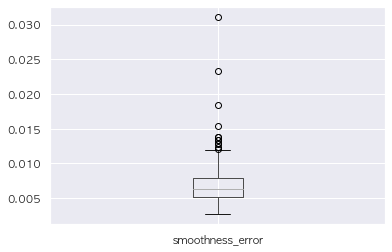

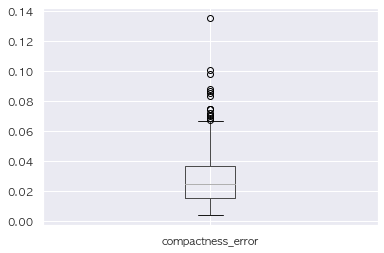

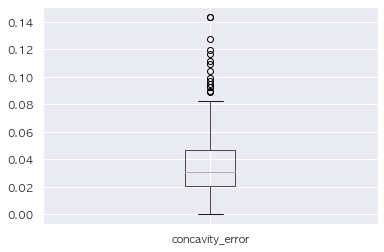

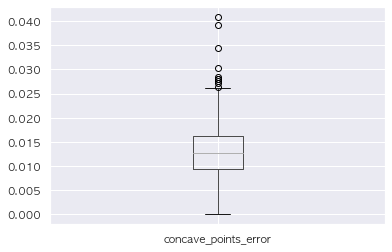

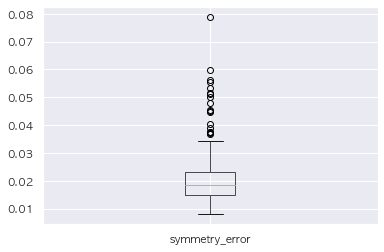

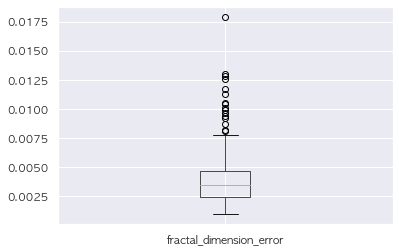

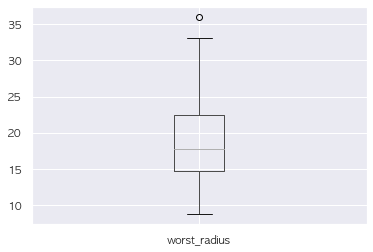

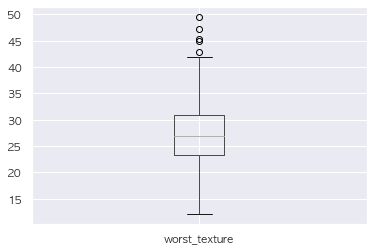

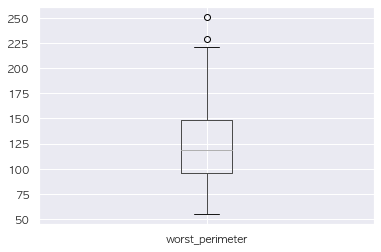

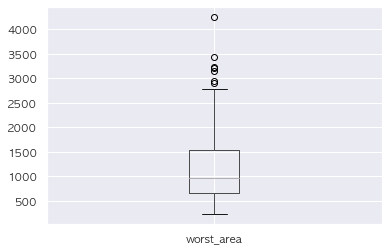

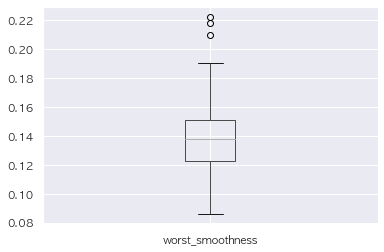

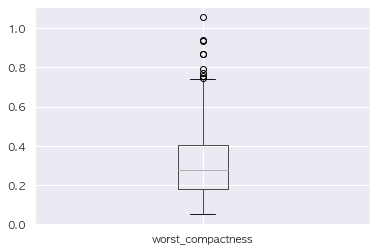

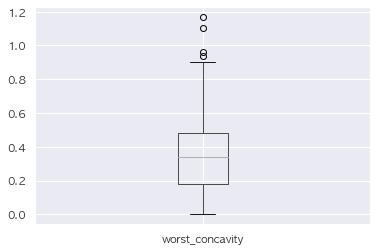

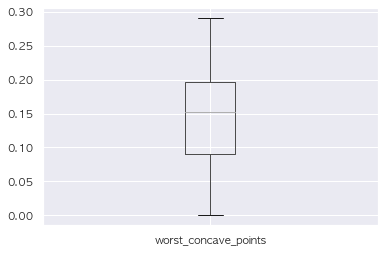

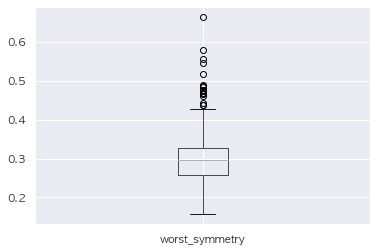

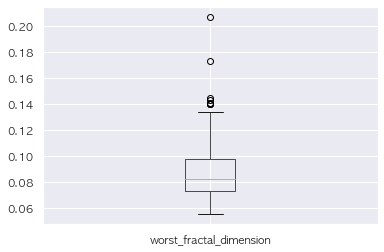

In [6]:
df_x = df.drop(['diagnosis'],axis=1)

for col in df_x.columns:
    df_x[[col]].boxplot()
    plt.show()
    plt.close()

# 데이터 변환: 목표 변수인 유방암 진단결과를 0(음성),1(양성)로 변환


In [7]:
df.replace({'diagnosis': '양성'}, 1, inplace=True)
df.replace({'diagnosis': '음성'}, 0, inplace=True)

In [32]:
df_train, df_test = train_test_split(df, test_size = 0.3, random_state=1234)
print('train data size : {}'.format(df_train.shape))
print('test data size : {}'.format(df_test.shape))

train data size : (224, 31)
test data size : (96, 31)


In [33]:
feature_columns = list(df.columns.difference(["diagnosis"]))
namesum = ''
for ct, name in enumerate(feature_columns):
    namesum+=name
    if ct<len(feature_columns)-1:
        namesum+=' + '
namesum

'area_error + compactness_error + concave_points_error + concavity_error + fractal_dimension_error + mean_area + mean_compactness + mean_concave_points + mean_concavity + mean_fractal_dimension + mean_perimeter + mean_radius + mean_smoothness + mean_symmetry + mean_texture + perimeter_error + radius_error + smoothness_error + symmetry_error + texture_error + worst_area + worst_compactness + worst_concave_points + worst_concavity + worst_fractal_dimension + worst_perimeter + worst_radius + worst_smoothness + worst_symmetry + worst_texture'

In [34]:
y='diagnosis' +' ~ '
x=namesum
print(y+x)

diagnosis ~ area_error + compactness_error + concave_points_error + concavity_error + fractal_dimension_error + mean_area + mean_compactness + mean_concave_points + mean_concavity + mean_fractal_dimension + mean_perimeter + mean_radius + mean_smoothness + mean_symmetry + mean_texture + perimeter_error + radius_error + smoothness_error + symmetry_error + texture_error + worst_area + worst_compactness + worst_concave_points + worst_concavity + worst_fractal_dimension + worst_perimeter + worst_radius + worst_smoothness + worst_symmetry + worst_texture


In [39]:
lodg_model = Logit.from_formula('diagnosis ~ area_error + compactness_error + concave_points_error + concavity_error + fractal_dimension_error + mean_area + mean_compactness + mean_concave_points + mean_concavity + mean_fractal_dimension + mean_perimeter + mean_radius + mean_smoothness + mean_symmetry + mean_texture + perimeter_error + radius_error + smoothness_error + symmetry_error + texture_error + worst_area + worst_compactness + worst_concave_points + worst_concavity + worst_fractal_dimension + worst_perimeter + worst_radius + worst_smoothness + worst_symmetry + worst_texture', df_train)

log_result = log_model.fit(method='cg')
print(log_result.summary())

         Current function value: 0.190680
         Iterations: 35
         Function evaluations: 98
         Gradient evaluations: 92
                           Logit Regression Results                           
Dep. Variable:              diagnosis   No. Observations:                  224
Model:                          Logit   Df Residuals:                      193
Method:                           MLE   Df Model:                           30
Date:                Thu, 26 Aug 2021   Pseudo R-squ.:                  0.7118
Time:                        13:08:56   Log-Likelihood:                -42.712
converged:                      False   LL-Null:                       -148.19
Covariance Type:            nonrobust   LLR p-value:                 4.331e-29
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   0.0115     19.750     

/Users/dasol/opt/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:1799: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/dasol/opt/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:1852: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/Users/dasol/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [27]:
y_pred = log_result.predict(df_test)
y_pred_class = (y_pred > 0.5).astype(int)
y_pred_class.head()

1721    0
822     0
1686    0
789     0
165     0
dtype: int64

In [29]:
print('Accuracy: %.3f \n'% accuracy_score(df_test['BAD'], y_pred_class))
print('Confusion Matrix: \n{} '.format(confusion_matrix(df_test['BAD'], y_pred_class)))
print()
print(classification_report(df_test['BAD'], y_pred_class, digits=3))

Accuracy: 0.922 

Confusion Matrix: 
[[1016    5]
 [  83   21]] 

              precision    recall  f1-score   support

           0      0.924     0.995     0.958      1021
           1      0.808     0.202     0.323       104

    accuracy                          0.922      1125
   macro avg      0.866     0.599     0.641      1125
weighted avg      0.914     0.922     0.900      1125



<AxesSubplot:>

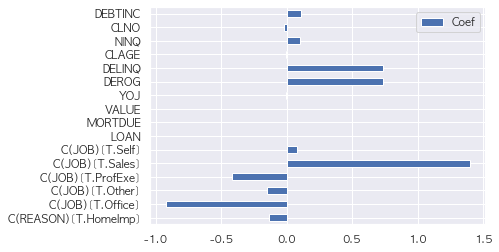

In [30]:
df_logistic_coef = pd.DataFrame({'Coef': log_result.params.values[1:]}, index = log_model.exog_names[1:])
df_logistic_coef.plot.barh(y = 'Coef')

In [31]:
df_char = df.select_dtypes(include = 'object')
df_numeric = df.select_dtypes(exclude = 'object')

scaler = StandardScaler()
np_numeric_scaled = scaler.fit_transform(df_numeric)
df_numeric_scaled = pd.DataFrame(np_numeric_scaled, columns = df_numeric.columns)

df_scaled = pd.concat([df_numeric_scaled, df_char], axis = 1)
df_scaled.head()

,BAD,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,REASON,JOB
0,3.140664,-1.559587,-0.993626,-1.222620,-0.017076,-0.267462,-0.341184,-0.962555,-0.018635,-1.428350,0.356347,HomeImp,Other
1,3.140664,-1.550817,-1.039240,-1.172701,0.244826,-0.267462,-0.341184,-1.116501,-0.661630,-1.428350,0.329025,HomeImp,Other
2,-0.318404,-1.506968,0.607570,0.260485,-0.933731,-0.267462,-0.341184,-1.089512,-0.661630,-0.905133,-0.303684,HomeImp,Office
3,3.140664,-1.498198,-0.897428,-1.091090,0.375777,-0.267462,-0.341184,-1.338025,-0.018635,-0.067985,0.493725,HomeImp,Mgr
4,-0.318404,-1.498198,0.520156,0.191363,-0.671830,-0.267462,-0.341184,-1.055338,-0.661630,-0.905133,-0.531456,HomeImp,Office


In [33]:
df_scaled['BAD'] = np.where(df_scaled['BAD'] > 0,1,0)
df_scaled.head()

,BAD,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,REASON,JOB
0,1,-1.559587,-0.993626,-1.222620,-0.017076,-0.267462,-0.341184,-0.962555,-0.018635,-1.428350,0.356347,HomeImp,Other
1,1,-1.550817,-1.039240,-1.172701,0.244826,-0.267462,-0.341184,-1.116501,-0.661630,-1.428350,0.329025,HomeImp,Other
2,0,-1.506968,0.607570,0.260485,-0.933731,-0.267462,-0.341184,-1.089512,-0.661630,-0.905133,-0.303684,HomeImp,Office
3,1,-1.498198,-0.897428,-1.091090,0.375777,-0.267462,-0.341184,-1.338025,-0.018635,-0.067985,0.493725,HomeImp,Mgr
4,0,-1.498198,0.520156,0.191363,-0.671830,-0.267462,-0.341184,-1.055338,-0.661630,-0.905133,-0.531456,HomeImp,Office


In [34]:
df_scaled_train, df_scaled_test = train_test_split(df_scaled,
                                                  test_size = 0.3,
                                                  random_state = 1234)

In [35]:
scaled_log_model = Logit.from_formula('BAD ~ LOAN + MORTDUE + VALUE + C(REASON) + C(JOB) + YOJ + DEROG + DELINQ + CLAGE + NINQ + CLNO + DEBTINC',
                              df_scaled_train)

scaled_log_result = scaled_log_model.fit()
print(scaled_log_result.summary())

Optimization terminated successfully.
         Current function value: 0.228666
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                    BAD   No. Observations:                 2355
Model:                          Logit   Df Residuals:                     2338
Method:                           MLE   Df Model:                           16
Date:                Thu, 26 Aug 2021   Pseudo R-squ.:                  0.2467
Time:                        11:14:53   Log-Likelihood:                -538.51
converged:                       True   LL-Null:                       -714.90
Covariance Type:            nonrobust   LLR p-value:                 2.710e-65
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -2.5795      0.221    -11.676      0.000      -3.013      -2.147

<AxesSubplot:>

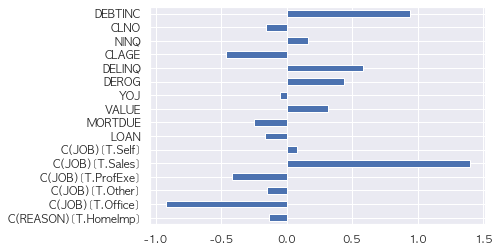

In [36]:
df_log_scaled_coef = pd.DataFrame({'Coef' : scaled_log_result.params.values[1:]},
                                 index = scaled_log_model.exog_names[1:])

df_log_scaled_coef.plot.barh(y='Coef', legend=False)